# Tutorial PAMAP2 with mcfly

The goal of this tutorial is to get you familiar with training Neural Networks for time series. At the end of the tutorial, you will have compared several Neural Network architectures you know how to train the best performing network. To quickly be able to compare several different deep learning architectures, we will use the Python libraray `mcfly`.

As an example dataset we use the publicly available [PAMAP2 dataset](https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring). It contains time series data from movement sensors worn by nine individuals. The data is labelled with the activity types that these individuals did and the aim is to train and evaluate a *classifier*.

Before you can start, please make sure you install mcfly (see the [mcfly installation page](https://github.com/NLeSC/mcfly)).

## Import required Python modules

In [1]:
#!pip install mcfly

  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached protobuf-3.19.6-cp39-cp39-win_amd64.whl (895 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3


In [2]:
import sys
import os
import numpy as np
import pandas as pd
# mcfly
import mcfly
import tensorflow as tf
np.random.seed(2)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
sys.path.insert(0, os.path.abspath('../..'))
import pamap2_utils as utils

## Download data pre-procesed data

We have created a function for you to fetch the preprocessed data from https://zenodo.org/record/834467. Please specify the `directory_to_extract_to` in the code below and then execute the cell. This will download the preprocessed data into the directory in the `data` subdirectory. The output of the function is the path where the preprocessed data was stored.

In [4]:
# Specify in which directory you want to store the data:
directory_to_extract_to = 'data/'

In [5]:
data_path = utils.download_preprocessed_data(directory_to_extract_to)

Extracting data...
Done


## A bit about the data

The [PAMAP2 dataset](https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring) contains data from three movement sensors worn on the hand, ankle and chest by nine test subjects. These subjects performed a protocol of several activities.

Each sensor has three channels (acceleration on x, y and z axes). This gives us, for each time step, 9 values. The data is recorded on 100 Hz.

The preprocessed data is split into smaller segments with a window of 512 time steps, corresponding to 5.12 seconds. We only include segments that completely fall into one activity period: the activity is the *label* of the segment.

The goal of classification is to assign an activity label to an previously unseen segment.

## Load the pre-processed data

Load the preprocessed data as stored in Numpy-files. Please note that the data has already been split up in a training (\~91%), validation (\~1%), and test (\~8%) subsets. It is common practice to call the input data X and the labels y.

In [6]:
X_train, y_train_binary, X_val, y_val_binary, X_test, y_test_binary, labels = utils.load_data(data_path)

Data X and labels y are of type Numpy array. In the cell below we inspect the shape of the data. As you can see the shape of X is expressed as a Python tuple containing: the number of samples, length of the time series, and the number of channels for each sample. Similarly, the shape of y is represents the number of samples and the number of classes (unique labels). Note that y has the format of a binary array where only the correct class for each sample is assigned a 1. This is called one-hot-encoding.

In [7]:
print('X training shape:', X_train.shape)
print('y training shape:', y_train_binary.shape)
print('y validation shape:', y_val_binary.shape)
print('y test shape:', y_test_binary.shape)

X training shape: (11397, 512, 9)
y training shape: (11397, 7)
y validation shape: (100, 7)
y test shape: (1000, 7)


The data is split between train test and validation.

Let's have a look at the distribution of the labels:

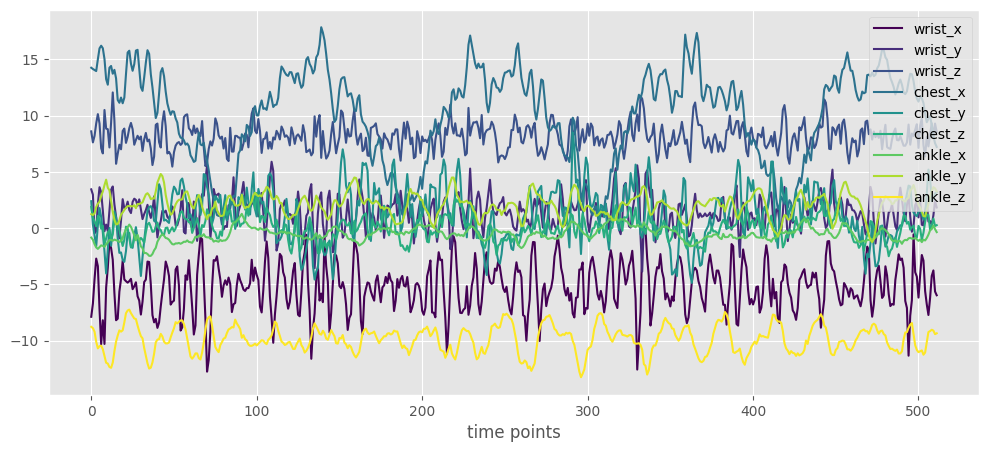

In [19]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

data_labels = ["wrist_x", "wrist_y", "wrist_z",
               "chest_x", "chest_y", "chest_z",
               "ankle_x", "ankle_y", "ankle_z"]

# Get the viridis colormap
cmap = plt.cm.get_cmap('viridis', len(data_labels))

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

for i, label in enumerate(data_labels):
    ax.plot(np.array(X_train[5, :, i]), color=cmap(i), label=label)

ax.set_xlabel('time points')
ax.legend()
plt.show()

In [23]:
print(y_train_binary[5])
labels

[0. 0. 0. 0. 1. 0. 0.]


['lying',
 'sitting',
 'standing',
 'walking',
 'cycling',
 'vaccuum_cleaning',
 'ironing']

In [25]:
frequencies = y_train_binary.mean(axis=0)
# inspect frequencies
frequencies_df = pd.DataFrame({'label': labels, 'frequency': frequencies})
frequencies_df

,label,frequency
0,lying,0.136615
1,sitting,0.130736
2,standing,0.136703
3,walking,0.176625
4,cycling,0.118540
5,vaccuum_cleaning,0.125208
6,ironing,0.175573


### *Question 1: How many channels does this dataset have?*
### *Question 2: What is the least common activity label in this dataset?*

    

## Generate models

First step in the development of any deep learning model is to create a model architecture. As we do not know what architecture is best for our data we will create a set of random models to investigate which architecture is most suitable for our data and classification task. This process, creating random models, checking how good they are and then selecting the best one is called a 'random search'. A random search is considered to be the most robust approach to finding a good model. You will need to specificy how many models you want to create with argument 'number_of_models'. See for a full overview of the optional arguments the function documentation of modelgen.generate_models by running `modelgen.generate_models?`.

##### What number of models to select?
This number differs per dataset. More models will give better results but it will take longer to evaluate them. For the purpose of this tutorial we recommend trying only 2 models to begin with. If you have enough time you can try a larger number of models, e.g. 10 or 20 models. Because mcfly uses random search, you will get better results when using more models.

In [26]:
num_classes = len(labels)
metric = 'accuracy'
models = mcfly.modelgen.generate_models(X_train.shape,
                                        number_of_output_dimensions=num_classes,
                                        number_of_models = 4,
                                        metrics=[metric]
                                       )

c:\Users\Phili\anaconda3\envs\chatbots\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Inspect the models
We can have a look at the models that were generated. The layers are shown as table rows. Most common layer types are 'Convolution' and 'LSTM' and 'Dense'. For more information see the [mcfly user manual](https://github.com/NLeSC/mcfly/wiki/User-manual) and the [tutorial cheat sheet](https://github.com/NLeSC/mcfly-tutorial/blob/master/cheatsheet.md). The summary also shows the data shape of each layer output and the number of parameters that are trained within this layer.

In [27]:
models_to_print = range(len(models))
for i, item in enumerate(models):
    if i in models_to_print:
        model, params, model_types = item
        print("-------------------------------------------------------------------------------------------------------")
        print("Model " + str(i), '\n')          
        print("Model type:", model_types, '\n')        
        print("Hyperparameters:")
        print(params)
        print(" ")
        print("Model description:")
        model.summary()        
        print(" ")

-------------------------------------------------------------------------------------------------------
Model 0 

Model type: ResNet 

Hyperparameters:
{'learning_rate': 0.0022439468517196116, 'regularization_rate': 0.004943480463153602, 'network_depth': 2, 'min_filters_number': 39, 'max_kernel_size': 10}
 
Model description:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 9)]     0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 9)      36          ['input_1[0][0]']                
 alization)                                                                                       
                                                               

## Compare models
Now that the model architectures have been generated it is time to compare the models by training them on a subset of the training data and evaluating the models on the validation subset. This will help us to choose the best candidate model. The performance results for the models are stored in a json file, which we will visually inspect later on.

In [29]:
# Define directory where the results, e.g. json file, will be stored
resultpath = os.path.join(directory_to_extract_to, 'data/models/accelerometer')
if not os.path.exists(resultpath):
    os.makedirs(resultpath)

We are now going to train each of the models that we generated. On the one hand we want to train them as quickly as possible in order to be able to pick the best one as soon as possible. On the other hand we have to train each model long enough to get a good impression of its potential.

We can influence the train time by adjusting the number of data samples that are used. This can be set with the argument 'subset_size'. We can also adjust the number of times the subset is iterated over. This number is called an epoch. We recommend to start with no more than 5 epochs and a maximum subset size of 300. You can experiment with these numbers.

In [30]:
outputfile = os.path.join(resultpath, 'modelcomparison.json')
histories, val_accuracies, val_losses = mcfly.find_architecture.train_models_on_samples(
    X_train, y_train_binary,
    X_val, y_val_binary,
    models,
    nr_epochs=4,
    subset_size=1000,
    early_stopping_patience=2,
    verbose=True,
    outputfile=outputfile,
    metric=metric)
print('Details of the training process were stored in ',outputfile)

Generated models will be trained on subset of the data (subset size: 1000).
Training model 0 ResNet
Epoch 1/4


c:\Users\Phili\anaconda3\envs\chatbots\lib\site-packages\mcfly\find_architecture.py:137: UserWarning: Argument 'metric' is deprecated and will be ignored.
  warnings.warn("Argument 'metric' is deprecated and will be ignored.")


50/50 [==============================] - 12s 174ms/step - loss: 0.7729 - accuracy: 0.7460 - val_loss: 46.6790 - val_accuracy: 0.3700
Epoch 2/4
50/50 [==============================] - 8s 163ms/step - loss: 0.4307 - accuracy: 0.8700 - val_loss: 26.0054 - val_accuracy: 0.3000
Epoch 3/4
50/50 [==============================] - 8s 163ms/step - loss: 0.3218 - accuracy: 0.9000 - val_loss: 6.5025 - val_accuracy: 0.5800
Epoch 4/4
50/50 [==============================] - 8s 167ms/step - loss: 0.2832 - accuracy: 0.9140 - val_loss: 2.9811 - val_accuracy: 0.7200
Training model 1 InceptionTime
Epoch 1/4
50/50 [==============================] - 105s 2s/step - loss: 1.2963 - accuracy: 0.7310 - val_loss: 1147.9438 - val_accuracy: 0.1300
Epoch 2/4
50/50 [==============================] - 122s 2s/step - loss: 0.4280 - accuracy: 0.8630 - val_loss: 53.7568 - val_accuracy: 0.3800
Epoch 3/4
50/50 [==============================] - 121s 2s/step - loss: 0.2740 - accuracy: 0.9010 - val_loss: 2.4773 - val_accur

# Inspect model performance (Visualization)

We can inspect the learning process in the visualization tool on http://nlesc.github.io/mcfly/.

Alternatively, you can run the visualization from a local web service:
- Clone the mcfly github repository (if you haven't done so already for visualization)

 `git clone https://github.com/NLeSC/mcfly`


- navigate to the html folder:

 `cd mcfly/html`


- Start a web server. This can be done in various ways, for example:
 - `python3 -m http.server` (or. `python -m http.server`)

Notice the port number the web server is serving on. This is usually 8000.
With a web browser, navigate to [localhost:8000](localhost:8000). 

You need to upload the json file that contains the details of the training process. The following line of code shows the path to this file:

In [ ]:
outputfile

### *Question 5:  Look at the visualization. Which model performs best?*
### *Question 6:  Did you train all models with a sufficient number of iterations?*

# Inspect model performance (table)

Let's compare the performance of the models by showing the results as a table.

In [ ]:
metric = 'accuracy'
modelcomparisons = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_{}'.format(metric): [history.history[metric][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_{}'.format(metric): [history.history['val_{}'.format(metric)][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
modelcomparisons.to_csv(os.path.join(resultpath, 'modelcomparisons01.csv'))

modelcomparisons

# Second iteration

In [ ]:
# if you want --> run a second search iteration

In [35]:
models = mcfly.modelgen.generate_models(X_train.shape,
                                        number_of_output_dimensions=num_classes,
                                        number_of_models = 3,
                                        model_types = ['InceptionTime'],
                                        metrics=[metric]
                                       )

c:\Users\Phili\anaconda3\envs\chatbots\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
models_to_print = range(len(models))
for i, item in enumerate(models):
    if i in models_to_print:
        model, params, model_types = item
        print("-------------------------------------------------------------------------------------------------------")
        print("Model " + str(i), '\n')          
        print("Model type:", model_types, '\n')        
        print("Hyperparameters:")
        print(params)
        print(" ")
        print("Model description:")
        model.summary()        
        print(" ")

-------------------------------------------------------------------------------------------------------
Model 0 

Model type: InceptionTime 

Hyperparameters:
{'learning_rate': 0.004741712758572711, 'regularization_rate': 0.0030760874784206507, 'network_depth': 6, 'filters_number': 62, 'max_kernel_size': 87}
 
Model description:
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 512, 9)]     0           []                               
                                                                                                  
 batch_normalization_97 (BatchN  (None, 512, 9)      36          ['input_13[0][0]']               
 ormalization)                                                                                    
                                                         

In [37]:
outputfile = os.path.join(resultpath, 'modelcomparison2.json')
histories, val_accuracies, val_losses = mcfly.find_architecture.train_models_on_samples(
    X_train, y_train_binary,
    X_val, y_val_binary,
    models,
    nr_epochs=4,
    subset_size=1000, #normalerweise hoeher, nur zum testen. Aktuell overfitting
    early_stopping_patience=2,
    verbose=True,
    outputfile=outputfile,
    metric=metric)
print('Details of the training process were stored in ',outputfile)

Generated models will be trained on subset of the data (subset size: 1000).
Training model 0 InceptionTime
Epoch 1/4
11/50 [=====>........................] - ETA: 2:54 - loss: 1.2584 - accuracy: 0.6409

KeyboardInterrupt: 

In [42]:
models

[(<keras.engine.functional.Functional at 0x1d3a31124c0>,
  {'learning_rate': 0.004741712758572711,
   'regularization_rate': 0.0030760874784206507,
   'network_depth': 6,
   'filters_number': 62,
   'max_kernel_size': 87},
  'InceptionTime'),
 (<keras.engine.functional.Functional at 0x1d3a31c3610>,
  {'learning_rate': 0.0019013957308651832,
   'regularization_rate': 0.006579609441735624,
   'network_depth': 6,
   'filters_number': 52,
   'max_kernel_size': 32},
  'InceptionTime'),
 (<keras.engine.functional.Functional at 0x1d3a3219700>,
  {'learning_rate': 0.0006523858178152041,
   'regularization_rate': 0.00856523165407815,
   'network_depth': 6,
   'filters_number': 59,
   'max_kernel_size': 10},
  'InceptionTime')]

In [43]:
from mcfly.models.inception_time import InceptionTime
inception = InceptionTime(x_shape=(None,512,9),number_of_classes=7)

model =inception.create_model(filters_number=55, network_depth=4, max_kernel_size=30, learning_rate=0.003,regularization_rate=0.08)

c:\Users\Phili\anaconda3\envs\chatbots\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [44]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 512, 9)]     0           []                               
                                                                                                  
 batch_normalization_124 (Batch  (None, 512, 9)      36          ['input_16[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 conv1d_374 (Conv1D)            (None, 512, 32)      288         ['batch_normalization_124[0][0]']
                                                                                                  
 max_pooling1d_68 (MaxPooling1D  (None, 512, 9)      0           ['batch_normalization_124[

In [45]:
model.fit(X_train, y_train_binary, epochs=1, validation_data=(X_val, y_val_binary))

357/357 [==============================] - 468s 1s/step - loss: 0.1964 - accuracy: 0.9357 - val_loss: 0.1223 - val_accuracy: 0.9400


# Choose the best model
Now that we found an effective architecture, we can choose the most promising model. For example, we can choose the model with the highest accuracy on the validation data set. To maximize this models performance, we will train this model on more data and more epochs.

In [ ]:
best_model_index = np.argmax(val_accuracies)
best_model, best_params, best_model_types = models[best_model_index]
print('Model type and parameters of the best model:')
print(best_model_types)
print(best_params)

## Train the best model on the full dataset

Now that we have identified the best model architecture out of our random pool of models we can continue by training the model on the full training set.

This would take some time, so instead we will train  on only a slightly larger subset.

In [ ]:
# Continue training? Or train new model?

### Saving, loading and comparing reloaded model with original model

The model can be saved for future use. The savemodel function will save two separate files: a json file for the architecture and a npy (numpy array) file for the weights.

## Investigate model predictions

We will now dive further into the Neural network that we created.
We provide here a network that has been trained on the complete train set.

Note that the objects `models`, `best_model_fullytrained` and `best_model` that resulted from the mcfly functions are Keras objects. This means that you can use Keras functions on the objects, for example  `.predict`, (which when given the data, outputs the predictions for each sample) and `.evaluate` (which when given the data and the labels computes how well this model performs) . These functions are all documented in the [Keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras). 

In [46]:
## Inspect model predictions on validation data
datasize = X_val.shape[0]
probs = model.predict(X_val, batch_size=1)

100/100 [==============================] - 2s 16ms/step


Let's have a look at the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

In [47]:
#columns are predicted, rows are truth
predicted = probs.argmax(axis=1)
y_index = y_val_binary.argmax(axis=1)
confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
confusion_matrix.index = [f"{labels[i]} (predicted)" for i in confusion_matrix.index]
confusion_matrix.columns = [labels[i] for i in confusion_matrix.columns]
confusion_matrix.reindex(columns=[l for l in labels], fill_value=0)
confusion_matrix

,lying,sitting,standing,walking,cycling,vaccuum_cleaning,ironing
lying (predicted),13,0,0,0,0,0,0
sitting (predicted),0,11,2,0,1,0,0
standing (predicted),0,0,20,0,0,0,0
walking (predicted),0,0,0,15,0,0,0
cycling (predicted),0,0,0,0,12,0,0
vaccuum_cleaning (predicted),0,0,0,0,0,8,0
ironing (predicted),0,1,0,0,0,2,15


In [49]:
## Test on Testset
score_test = model.evaluate(X_test, y_test_binary, verbose=True)
print('Score of best model: ' + str(score_test))

32/32 [==============================] - 7s 213ms/step - loss: 0.1730 - accuracy: 0.9400
Score of best model: [0.17303594946861267, 0.9399999976158142]


In [50]:
model.save("my_model.keras") #als keras format, beinhaltet alle infos und das model